<a href="https://colab.research.google.com/github/sweeneyngo/furspect/blob/master/multiclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

! pip install -q kaggle
from google.colab import files 
files.upload()
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alessiocorrado99/animals10

Mounted at /content/drive


Saving kaggle.json to kaggle.json
100% 585M/586M [00:11<00:00, 63.6MB/s]
100% 586M/586M [00:11<00:00, 52.2MB/s]


In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
!unzip animals10.zip

In [ ]:
!rm -rf animals10.zip

In [ ]:
# main folder
classes = os.listdir('raw-img')
classes

['elefante',
 'cavallo',
 'scoiattolo',
 'pecora',
 'ragno',
 'mucca',
 'gallina',
 'cane',
 'farfalla',
 'gatto']

In [ ]:
# organize dataset into a useful structure
from shutil import copyfile 

from random import seed    
from random import random

# create directories
subdirs = ['train', 'validation']

for subdir in subdirs:

  # create label subdirectories
  for label in classes:
    new = os.path.join(subdir, label)
    os.makedirs(new, exist_ok=True)

In [ ]:
# seed random number generator
seed(1)

for label in classes:

  head = os.path.join('raw-img', label)

  for file in os.listdir(head):
    src = os.path.join(head, file)
    dst = os.path.join(subdirs[0], label, file)

    if random() < 0.2:
      dst = os.path.join(subdirs[1], label, file)

    print(f'Travelling from {src} to {dst}!')
    copyfile(src, dst)
    


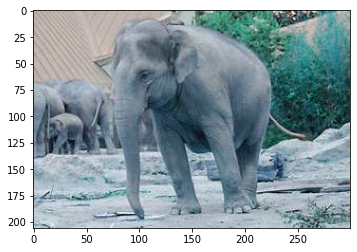

In [ ]:
# sample image

path = os.path.join('validation', 'elefante')
files = os.listdir(path)
img = cv2.imread(os.path.join(path, files[0]))
plt.imshow(img, cmap=plt.cm.binary)

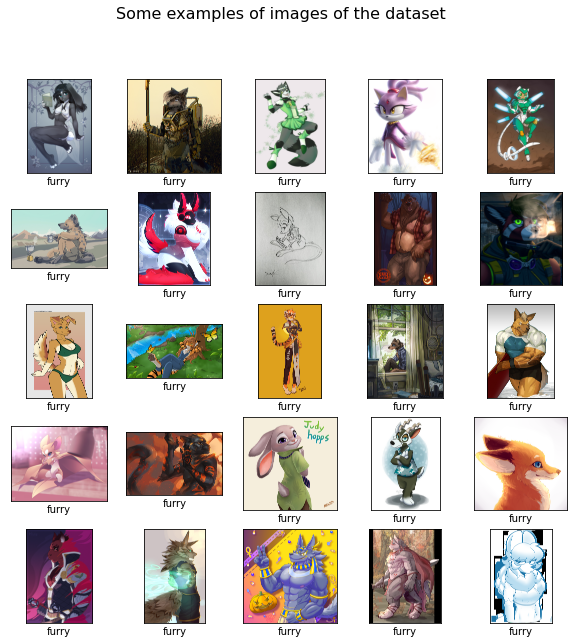

In [ ]:
import os
from matplotlib import pyplot as plt

def display_examples(folder):
    """
        Display 25 images from the images array with its corresponding labels
    """
    path = os.path.join('train/', folder)
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        images = os.listdir(path)
        idx = np.random.randint(0, len(images))
        arr = cv2.imread(os.path.join(path, images[idx]))
        arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)
        plt.imshow(arr, cmap=plt.cm.binary)
        plt.xlabel(folder)
    plt.show()
    
display_examples('furry')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

path = os.path.join('')
# create data generators
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

# keep test images unmodified
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
train_it = train_datagen.flow_from_directory(os.path.join(path, 'train'),
    class_mode='categorical', batch_size=32, target_size=(200, 200))
val_it = val_datagen.flow_from_directory(os.path.join(path, 'validation'),
    class_mode='categorical', batch_size=32, target_size=(200, 200))

print('Initiated data generators.')

Found 22681 images belonging to 11 classes.
Found 5761 images belonging to 11 classes.
Initiated data generators.


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import os
path = os.path.join('')



datagen = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        samplewise_center = True,
        )

val_datagen = ImageDataGenerator(rescale=1./255,
        samplewise_center = True,
        )
# datagen = ImageDataGenerator(featurewise_center=True)
# # specify imagenet mean values for centering
# datagen.mean = [123.68, 116.779, 103.939]

# # create data generators
# train_datagen = ImageDataGenerator(rescale=1.0/255.0)

# # keep test images unmodified
# val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# prepare iterators
# train_it = train_datagen.flow_from_directory(os.path.join(path, 'train'),
#     class_mode='categorical', batch_size=32, target_size=(200, 200))
# val_it = val_datagen.flow_from_directory(os.path.join(path, 'validation'),
#     class_mode='categorical', batch_size=32, target_size=(200, 200))

train_it = datagen.flow_from_directory(os.path.join(path, 'train'),
    class_mode='categorical', interpolation = 'lanczos', batch_size=32, target_size=(224, 224))
val_it = val_datagen.flow_from_directory(os.path.join(path, 'validation'),
    class_mode='categorical', interpolation = 'lanczos', batch_size=32, target_size=(224, 224))


print('Initiated data generators.')

Found 22681 images belonging to 11 classes.
Found 5761 images belonging to 11 classes.
Initiated data generators.


**kerasTuner modelling**

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
!pip install -q -U keras-tuner

import kerastuner as kt

def model_builder(hp):

  model = Sequential()

  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2), padding='same'))
      
  model.add(Flatten())
  model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
  model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(11, activation='softmax'))

  # compile model
  # opt = SGD(lr=0.001, momentum=0.9)

  # hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy']) #1e-4
  model.summary()
  return model


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  if __name__ == '__main__':


**Manual modelling**

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(200, 200, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
  

model.add(Flatten())
model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(11, activation='softmax'))

# compile model
# opt = SGD(lr=0.001, momentum=0.9)

# hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy']) #1e-4
model.summary()

In [ ]:
# add new classifier layers
from tensorflow.keras import layers
from keras.applications.vgg16 import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D, BatchNormalization

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator


base = VGG16(include_top=False, input_shape=(224, 224, 3))

model = Sequential()
model.add(base)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(11, activation='softmax'))

for layer in base.layers:
  layer.trainable = False

model.layers[0].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
model.build(input_shape=(None, 224, 224, 3))
# define new model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_1 (ModuleWrap (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_3 (Dense)              (None, 11)                2827      
Total params: 21,140,299
Trainable params: 6,425,611
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10, overwrite = True)

In [ ]:
tuner.search(train_it, steps_per_epoch=len(train_it) // 32,
      validation_data=val_it, validation_steps=len(val_it) // 32, epochs=50, verbose=1, callbacks=[callbacks])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps['conv_layers']

In [ ]:
best_model = tuner.get_best_models()[0]
best_model.save('furspect_c.h5')

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(monitor='val_loss', patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience=1, verbose = 1,factor = 0.2, min_lr = 1e-8, min_delta=0.0001)
# mc = ModelCheckpoint('furspect_best.h5', monitor='val_accuracy', mode='max', verbose=1)
callbacks = [earlystop, learning_rate_reduction]

In [ ]:
from tensorflow.keras.models import load_model

# model = load_model('furspect_c.h5')
history = model.fit(train_it,
      validation_data=val_it, epochs=50, verbose=1, callbacks=[callbacks], shuffle=False)
  # 

Epoch 1/50
449/709 [=================>............] - ETA: 3:59 - loss: 1.0603 - accuracy: 0.6829

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (152924744 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


508/709 [====================>.........] - ETA: 3:06 - loss: 1.0208 - accuracy: 0.6923

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


709/709 [==============================] - 765s 1s/step - loss: 0.9253 - accuracy: 0.7154 - val_loss: 0.5940 - val_accuracy: 0.7992
Epoch 2/50
709/709 [==============================] - 734s 1s/step - loss: 0.5882 - accuracy: 0.8063 - val_loss: 0.4342 - val_accuracy: 0.8587
Epoch 3/50
709/709 [==============================] - 741s 1s/step - loss: 0.5207 - accuracy: 0.8254 - val_loss: 0.4541 - val_accuracy: 0.8558

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/50
709/709 [==============================] - 730s 1s/step - loss: 0.4066 - accuracy: 0.8630 - val_loss: 0.3562 - val_accuracy: 0.8821
Epoch 5/50
709/709 [==============================] - 714s 1s/step - loss: 0.3807 - accuracy: 0.8721 - val_loss: 0.3531 - val_accuracy: 0.8840
Epoch 6/50
709/709 [==============================] - 737s 1s/step - loss: 0.3764 - accuracy: 0.8733 - val_loss: 0.3484 - val_accuracy: 0.8880
Epoch 7/50
709/709 [==============================] - 747s 1s/step - lo

In [ ]:
    # evaluate model
    _, acc = model.evaluate(val_it, steps=len(val_it), verbose=1)
    print('> %.3f' % (acc * 100.0))

181/181 [==============================] - 47s 259ms/step - loss: 1.7612 - accuracy: 0.4083
> 40.826


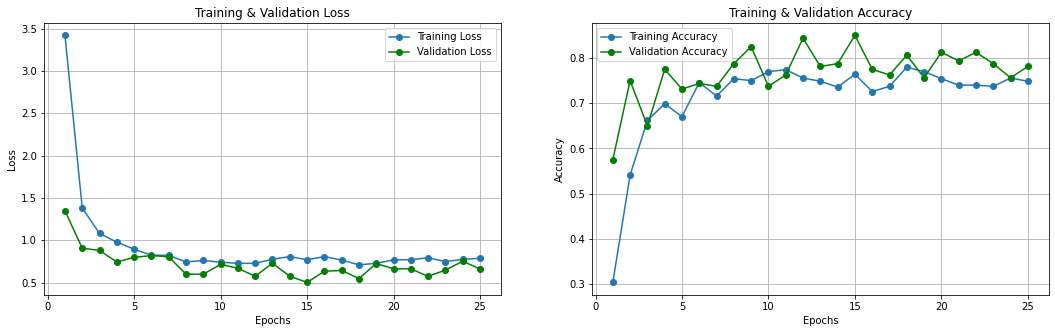

In [ ]:
from matplotlib import pyplot

loss_vals = history.history['loss']
val_loss_vals = history.history['val_loss']



epochs = range(1, len(history.history['accuracy'])+1)

f, ax = plt.subplots(nrows=1,ncols=2,figsize=(18,5))
    
ax[0].plot(epochs, loss_vals,  marker='o', label='Training Loss')
ax[0].plot(epochs, val_loss_vals, marker='o', color = 'green', label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='best')
ax[0].grid(True)

acc_vals = history.history['accuracy']
val_acc_vals = history.history['val_accuracy']

ax[1].plot(epochs, acc_vals, marker='o', label='Training Accuracy')
ax[1].plot(epochs, val_acc_vals, marker='o', color = 'green', label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend(loc='best')
ax[1].grid(True)

plt.show()
# pyplot.savefig(filename + '_plot.png')
pyplot.close()

train/pecora
OIP-1q8njpU3CldDJf9dMUecQwAAAA.jpeg


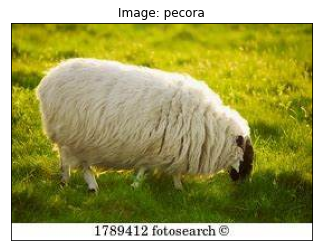

[0.40440565 0.03112656 0.02774293 0.03797792 0.00233776 0.02838124
 0.05833624 0.08051561 0.05128339 0.08347603 0.19441669]
0
cane


In [ ]:
# !pip install scikit-image
# !pip install opencv-python

from PIL import Image
import numpy as np
from skimage import transform
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
import cv2

path = 'train'
folder = os.listdir(os.path.join(path))
chosen = folder[np.random.randint(0, 11)]
dir = os.path.join(path, chosen)
print(dir)
images = os.listdir(dir)
# # load all images into a list
index = np.random.randint(0, len(images))
file = images[index]

print(file)


plt.figure()
arr = cv2.imread(os.path.join(dir, file))
arr = cv2.cvtColor(arr, cv2.COLOR_BGR2RGB)

plt.imshow(arr, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title(f'Image: {chosen}')
plt.show()

np_image = Image.open(os.path.join(dir, file))
np_image = np.array(np_image).astype('float32')/255
np_image = transform.resize(np_image, (200, 200, 3))
np_image = np.expand_dims(np_image, axis=0)
res = model.predict(np_image, batch_size=10)
classes = ['cane', 'cavallo', 'elefante', 'farfalla', 'furry', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
print(res[0][:])
print(np.argmax(res[0][:]))
print(classes[(np.argmax(res[0][:]))])




**Conjoining furry directory**

In [ ]:
!unzip drive/MyDrive/furry.zip

In [ ]:
label = 'furry'
for subdir in ['train', 'validation']:
  new = os.path.join(subdir, label)
  os.makedirs(new, exist_ok=True)

In [ ]:
seed(1)
head = os.path.join(label)

for file in os.listdir(head):
  src = os.path.join(head, file)
  dst = os.path.join('train', label, file)

  if random() < 0.2:
    dst = os.path.join('validation', label, file)

  print(f'Travelling from {src} to {dst}!')
  copyfile(src, dst)

In [ ]:
a = 'untitled_project'
for trial in os.listdir(a):
  b = os.path.join(a, trial)
  os.rmdir(b)

In [ ]:
for file in os.listdir(os.path.join('tuner_dir/furspect_'))

## **Analysis**

In [ ]:
train_classes = to_categorical(train_it.classes, num_classes=len(train_it.class_indices))

In [ ]:
val_classes = to_categorical(val_it.classes, num_classes=len(val_it.class_indices))
val_classes

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [ ]:
preds = np.round(model.predict(val_it, 0))
preds

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
model.evaluate(val_it, steps=len(val_it), verbose=1)

167/167 [==============================] - 16s 94ms/step - loss: 1.0589 - accuracy: 0.6432


[1.0589404106140137, 0.6431792378425598]

In [ ]:
from sklearn import metrics
class_report = metrics.classification_report(val_classes, preds, target_names=classes)
print(class_report)

              precision    recall  f1-score   support

        cane       0.21      0.04      0.07       966
     cavallo       0.14      0.00      0.01       546
    elefante       0.00      0.00      0.00       265
    farfalla       0.09      0.04      0.06       458
       furry       0.07      0.04      0.05       440
     gallina       0.14      0.02      0.03       616
       gatto       0.00      0.00      0.00       319
       mucca       0.00      0.00      0.00       388
      pecora       0.00      0.00      0.00       381
       ragno       0.17      0.09      0.11      1012
  scoiattolo       0.00      0.00      0.00       370

   micro avg       0.14      0.03      0.05      5761
   macro avg       0.08      0.02      0.03      5761
weighted avg       0.11      0.03      0.04      5761
 samples avg       0.03      0.03      0.03      5761



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import pandas as pd
categorical_val_classes = pd.DataFrame(val_classes).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [ ]:
cm = metrics.confusion_matrix(categorical_val_classes, categorical_preds)
cm

array([[804,   1,   0,  30,  39,   8,   0,   1,   0,  81,   2],
       [445,   2,   0,  24,  23,   5,   0,   0,   1,  45,   1],
       [228,   2,   0,   3,  11,   2,   0,   0,   0,  19,   0],
       [371,   0,   0,  19,  23,   6,   0,   0,   0,  39,   0],
       [359,   1,   0,  14,  17,   4,   0,   1,   0,  44,   0],
       [490,   0,   1,  20,  36,  10,   1,   0,   0,  57,   1],
       [251,   2,   0,  15,   9,   7,   0,   0,   0,  35,   0],
       [309,   3,   0,  16,  15,   4,   0,   0,   0,  41,   0],
       [311,   0,   0,  12,  18,   7,   0,   0,   0,  33,   0],
       [829,   2,   0,  41,  34,  13,   0,   4,   0,  87,   2],
       [300,   1,   0,  19,  13,   5,   0,   3,   0,  29,   0]])

In [ ]:
import matplotlib.pyplot as plt
import itertools

def plot_cm(cm, classes,
  normalize=False,
  title="confusion_matrix",
  cmap=plt.cm.Blues):

  #Add Normalization Option
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Unnormalized confusion matrix")
 
  plt.imshow(cm, interpolation="nearest", cmap=cmap)
  # plt.imshow(cm)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
 
  fmt = ".2f" if normalize else "d"
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

  plt.ylabel("True label")
  plt.xlabel("Predicted label") 

Normalized confusion matrix


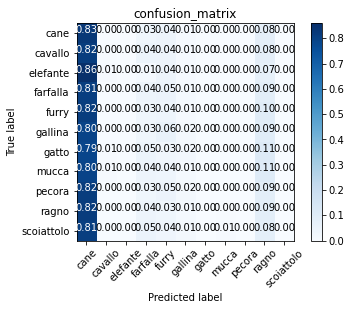

In [ ]:
plot_cm(cm, classes, normalize=True)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

print('Classification Report')
target_names = list(train.class_indices.keys())
print(classification_report(train.classes, y_pred, target_names=target_names))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(train.classes, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()